## Introduction
This notebook present the performances of the GaussianMixture class using a cholesky decomposition of the precision matrix.

In [1]:
%matplotlib inline

# To keep track of the machine this script is run in
import IPython; 
import platform;
import sklearn, numpy as np, scipy
from ast import literal_eval

CURR_IPYTHON_VERSION = IPython.__version__
PYTHON_INPT = literal_eval(IPython.sys_info())['sys_executable']
SKVERSION = sklearn.__version__; SCVERSION = scipy.__version__; NPVERSION = np.__version__
print("Running on %s" % platform.platform())
!echo -e "At host \"$(hostname)\" with $(nproc) cores. Current Dir - $(pwd)\n"
!echo -n "sklearn $SKVERSION "
print("@ %s\n" % str(sklearn.__path__))
!echo -e -n "np v$NPVERSION - scipy v$SCVERSION \nIPython v$CURR_IPYTHON_VERSION - "
!echo -n "$($PYTHON_INPT --version)"
!echo "@ $PYTHON_INPT"

Running on Linux-3.19.0-58-generic-x86_64-with-debian-jessie-sid
-e At host "caprica" with 4 cores. Current Dir - /home/zloten/Documents/sklearn-notebook/Benchmarks

sklearn 0.18.dev0 @ ['/home/zloten/Documents/scikit-learn/sklearn']

-e -n np v1.11.0 - scipy v0.17.0 
IPython v4.1.1 - 
Python 3.5.1 :: Continuum Analytics, Inc.
@ /home/zloten/anaconda3/envs/sklearn/bin/python


## Resulting Plots
A figure to visualy check the plot result of the different GaussianMixture fittings.

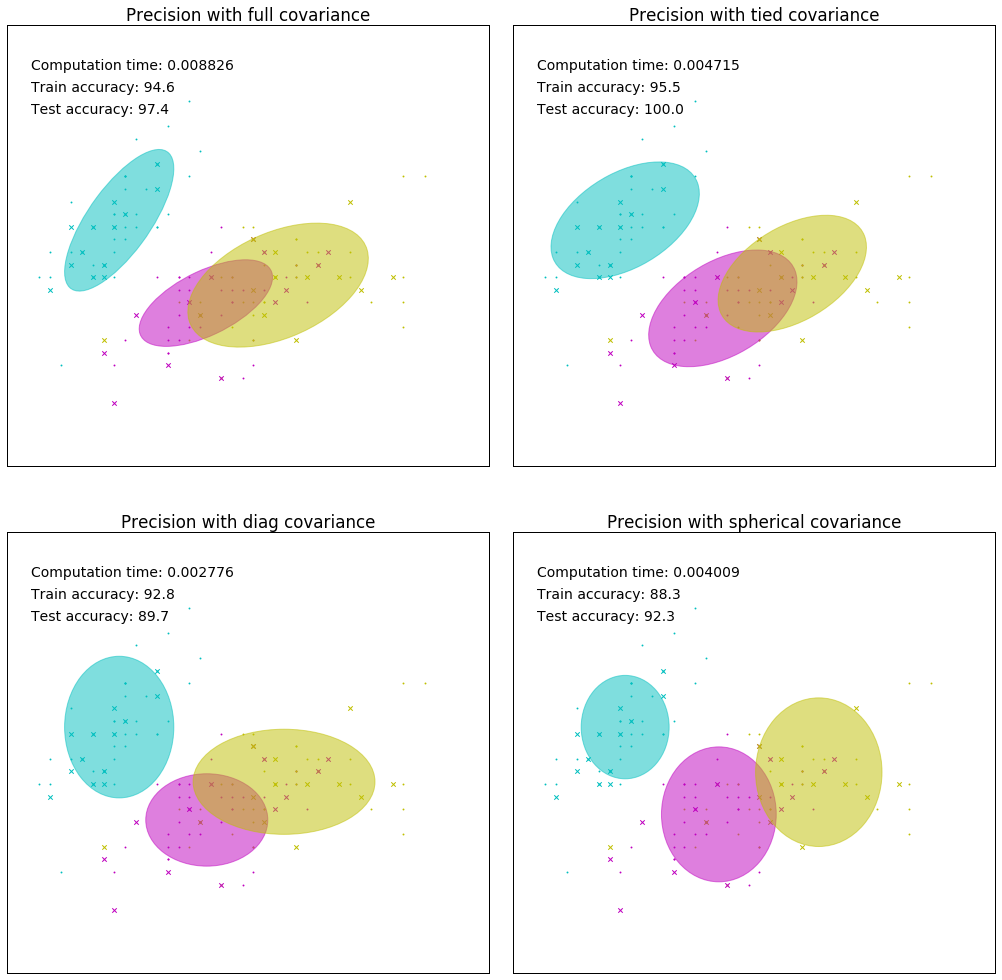

In [2]:
from time import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as linalg
from sklearn.mixture import GaussianMixture
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
from utils import *

plt.rcParams['figure.figsize'][:] = [14, 14]
plt.rcParams['font.size'] = 14.
plt.rcParams['axes.labelsize'] = 'large'

iris = datasets.load_iris()
skf = StratifiedKFold(n_folds=4)
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))

X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

means_init = np.array([X_train[y_train == i].mean(axis=0) for i in range(len(np.unique(y_train)))])
gmm = GaussianMixture(n_components=len(np.unique(y_train)), random_state=0, means_init=means_init)

plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05, left=.01, right=.99)
for index, cov_type in enumerate(['full', 'tied', 'diag', 'spherical']):
    gmm.covariance_type = cov_type
    
    computation_time = time()
    gmm.fit(X_train)
    computation_time = time() - computation_time
    
    h = plt.subplot(2, 2, index + 1)
    plot_ellipses(gmm.means_, gmm.covariances_, gmm.covariance_type, h) 
    plt.text(0.05, 0.9, 'Computation time: %f' % computation_time, transform=h.transAxes)

    for n in range(gmm.n_components):
        data = X_train[y_train == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=colors[n],
                label=iris.target_names[n])
    # Plot the test data with crosses
    for n in range(gmm.n_components):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=colors[n])

    y_train_pred = gmm.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.85, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = gmm.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title('Precision with %s covariance' % cov_type)
        
plt.show()

In [3]:
n_components, n_samples, n_features = 3, 100000, 10

rng = np.random.RandomState(0)

X = rng.rand(n_samples, n_features)

gmm = GaussianMixture(n_components=n_components)

In [4]:
def test_fit(gmm, X):
    for _ in range(10):
        gmm.fit(X)
        
%lprun -f GaussianMixture.fit test_fit(gmm, X)

```
Timer unit: 1e-06 s

Total time: 6.83063 s
File: /home/zloten/Documents/scikit-learn/sklearn/mixture/base.py
Function: fit at line 168

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
   168                                               def fit(self, X, y=None):
   169                                                   """Estimate model parameters with the EM algorithm.
   170                                           
   171                                                   The method fit the model `n_init` times and set the parameters with
   172                                                   which the model has the largest likelihood or lower bound. Within each
   173                                                   trial, the method iterates between E-step and M-step for `max_iter`
   174                                                   times until the change of likelihood or lower bound is less than
   175                                                   `tol`, otherwise, a `ConvergenceWarning` is raised.
   176                                           
   177                                                   Parameters
   178                                                   ----------
   179                                                   X : array-like, shape (n_samples, n_features)
   180                                                       List of n_features-dimensional data points. Each row
   181                                                       corresponds to a single data point.
   182                                           
   183                                                   Returns
   184                                                   -------
   185                                                   self
   186                                                   """
   187        10         7925    792.5      0.1          X = _check_X(X, self.n_components)
   188        10          152     15.2      0.0          self._check_initial_parameters(X)
   189                                           
   190                                                   # if we enable warm_start, we will have a unique initialisation
   191        10           32      3.2      0.0          do_init = not(self.warm_start and hasattr(self, 'converged_'))
   192        10           11      1.1      0.0          n_init = self.n_init if do_init else 1
   193                                           
   194        10           25      2.5      0.0          max_log_likelihood = -np.infty
   195        10           18      1.8      0.0          self.converged_ = False
   196                                           
   197        20           56      2.8      0.0          for init in range(n_init):
   198        10           33      3.3      0.0              self._print_verbose_msg_init_beg(init)
   199                                           
   200        10            9      0.9      0.0              if do_init:
   201        10      3873498 387349.8     56.7                  self._initialize_parameters(X)
   202        10       555307  55530.7      8.1              current_log_likelihood, resp = self._e_step(X)
   203                                           
   204        30          111      3.7      0.0              for n_iter in range(self.max_iter):
   205        30           28      0.9      0.0                  prev_log_likelihood = current_log_likelihood
   206                                           
   207        30       800075  26669.2     11.7                  self._m_step(X, resp)
   208        30      1592612  53087.1     23.3                  current_log_likelihood, resp = self._e_step(X)
   209        30          140      4.7      0.0                  change = current_log_likelihood - prev_log_likelihood
   210        30          247      8.2      0.0                  self._print_verbose_msg_iter_end(n_iter, change)
   211                                           
   212        30          152      5.1      0.0                  if abs(change) < self.tol:
   213        10           21      2.1      0.0                      self.converged_ = True
   214        10           11      1.1      0.0                      break
   215                                           
   216        10           37      3.7      0.0              self._print_verbose_msg_init_end(current_log_likelihood)
   217                                           
   218        10           18      1.8      0.0              if current_log_likelihood > max_log_likelihood:
   219        10           11      1.1      0.0                  max_log_likelihood = current_log_likelihood
   220        10           35      3.5      0.0                  best_params = self._get_parameters()
   221        10           10      1.0      0.0                  best_n_iter = n_iter
   222                                           
   223        10           10      1.0      0.0          if not self.converged_:
   224                                                       warnings.warn('Initialization %d did not converged. '
   225                                                                     'Try different init parameters, '
   226                                                                     'or increase n_init, tol '
   227                                                                     'or check for degenerate data.'
   228                                                                     % (init + 1), ConvergenceWarning)
   229                                           
   230        10           28      2.8      0.0          self._set_parameters(best_params)
   231        10           12      1.2      0.0          self.n_iter_ = best_n_iter
   232                                           
   233        10            8      0.8      0.0          return self
```

In [5]:
from sklearn.mixture.gaussian_mixture import _estimate_log_gaussian_prob_full

def test_score_samples(gmm, X):
    for _ in range(10):
        gmm.score_samples(X)
        
%lprun -f _estimate_log_gaussian_prob_full test_score_samples(gmm, X)

```
Timer unit: 1e-06 s

Total time: 0.288193 s
File: /home/zloten/Documents/scikit-learn/sklearn/mixture/gaussian_mixture.py
Function: _estimate_log_gaussian_prob_full at line 318

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
   318                                           def _estimate_log_gaussian_prob_full(X, means, precisions_chol):
   319                                               """Estimate the log Gaussian probability for 'full' precision.
   320                                           
   321                                               Parameters
   322                                               ----------
   323                                               X : array-like, shape (n_samples, n_features)
   324                                           
   325                                               means : array-like, shape (n_components, n_features)
   326                                           
   327                                               precisions_chol : array-like, shape (n_components, n_features, n_features)
   328                                                   Cholesky decompositions of the precision matrices.
   329                                           
   330                                               Returns
   331                                               -------
   332                                               log_prob : array, shape (n_samples, n_components)
   333                                               """
   334        10           32      3.2      0.0      n_samples, n_features = X.shape
   335        10           15      1.5      0.0      n_components, _ = means.shape
   336        10           61      6.1      0.0      log_prob = np.empty((n_samples, n_components))
   337        40          412     10.3      0.1      for k, (mu, prec_chol) in enumerate(zip(means, precisions_chol)):
   338        30         1148     38.3      0.4          log_det = -2. * np.sum(np.log(np.diagonal(prec_chol)))
   339        30       160935   5364.5     55.8          y = np.dot(X - mu, prec_chol)
   340        30          609     20.3      0.2          log_prob[:, k] = -.5 * (n_features * np.log(2. * np.pi) + log_det +
   341        30       124963   4165.4     43.4                                  np.sum(np.square(y), axis=1))
   342        10           18      1.8      0.0      return log_prob
```   